References
- https://pythonmachinelearning.pro/face-recognition-with-eigenfaces/
- https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Labelled Faces in the Wild Dataset

In [2]:
from sklearn.datasets import fetch_lfw_people

In [3]:
# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=100)

In [4]:
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
print(target_names)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


In [5]:
# observe count for each class
pd.Series(y).value_counts()

2    530
0    236
4    144
1    121
3    109
dtype: int64

In [6]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2, stratify = y)

# Helper Functions for Visualization

In [7]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure(figsize = (14, 6))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
        plt.subplots_adjust(hspace = 1.0, wspace = 1.0)

def titles(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)

# Finding Eigenfaces using SVD

In [8]:
U, S, VT = np.linalg.svd(X_train, full_matrices=False) 

In [9]:
print(U.shape, S.shape, VT.shape)

(798, 798) (798,) (798, 2914)


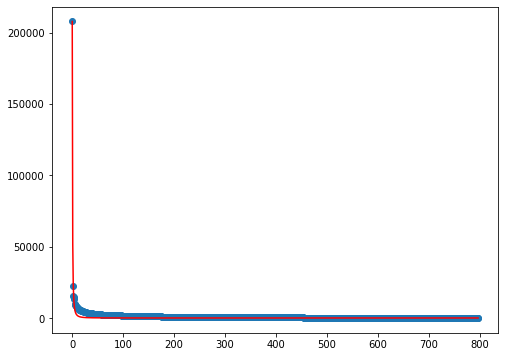

In [10]:
# observe how quickly singular values diminish - approximately as fast as sigma0/(i+1)^2
idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]

plt.figure(figsize = (8, 6))
plt.plot(idx, func, color = 'r')
plt.scatter(idx, S)

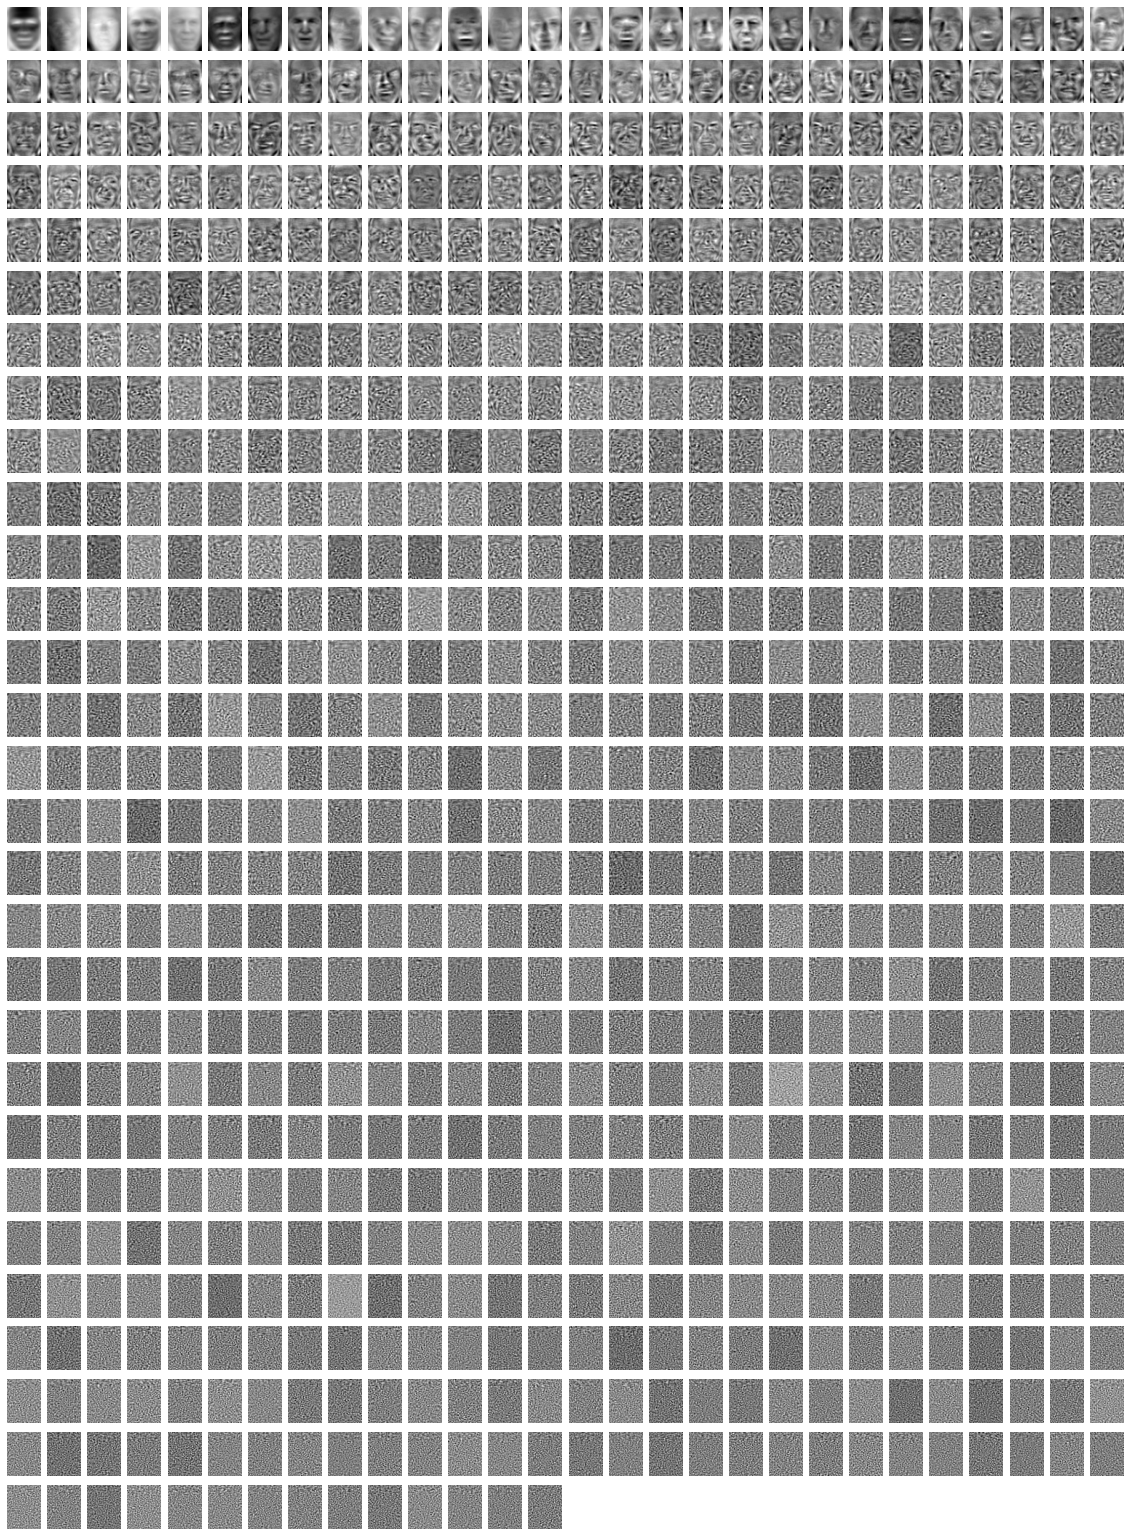

In [11]:
# plot all the eigenfaces
plt.figure(figsize = (20, 28))
for i in range(len(S)):
    plt.subplot(29, 28, i+1), plt.axis('off'), plt.imshow(VT[i].reshape(h, w), cmap = plt.cm.gray)

I decided randomly  to preserve 120 eigenfaces

In [0]:
num_components = 120

# transform both train and test data into new face space
X_train_transformed = X_train @ VT[:num_components,:].T
X_test_transformed = X_test @ VT[:num_components,:].T

In [13]:
print(X_train.shape, X_train_transformed.shape)

(798, 2914) (798, 120)


We have transformed from a 2914 dimensional space to a 120 dimensional space

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6a0eadada0>,
 Text(0.5, 1.0, 'Image in new face space'))

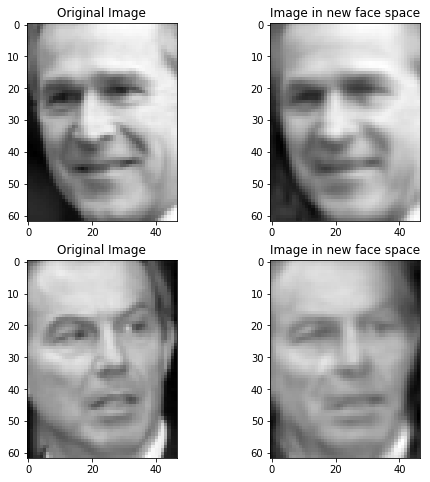

In [14]:
# visualize images after encoding as linear combination of eigenfaces
reconst0 = X_train_transformed[0] @ VT[: num_components, :]
reconst1 = X_train_transformed[1] @ VT[: num_components, :]

plt.figure(figsize = (8, 8))
plt.subplot(2, 2, 1), plt.imshow(X_train[0].reshape(h, w), cmap = plt.cm.gray), plt.title('Original Image')
plt.subplot(2, 2, 2), plt.imshow(reconst0.reshape(h, w), cmap = plt.cm.gray), plt.title('Image in new face space')
plt.subplot(2, 2, 3), plt.imshow(X_train[1].reshape(h, w), cmap = plt.cm.gray), plt.title('Original Image')
plt.subplot(2, 2, 4), plt.imshow(reconst1.reshape(h, w), cmap = plt.cm.gray), plt.title('Image in new face space')

# Classification using kNN

In [15]:
clfkNN = KNeighborsClassifier()
clfkNN.fit(X_train_transformed, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
y_predkNN = clfkNN.predict(X_test_transformed)
print(classification_report(y_test, y_predkNN, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.59      0.85      0.69        71
  Donald Rumsfeld       0.50      0.42      0.45        36
    George W Bush       0.72      0.81      0.76       159
Gerhard Schroeder       0.55      0.18      0.27        33
       Tony Blair       0.60      0.28      0.38        43

         accuracy                           0.65       342
        macro avg       0.59      0.51      0.51       342
     weighted avg       0.64      0.65      0.62       342



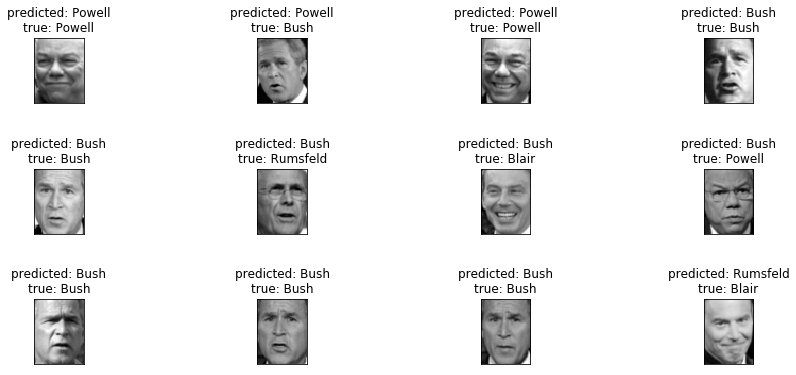

In [17]:
# observe some of the images with their predicted and true labels
prediction_titles = list(titles(y_predkNN, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

# Classification using Multi Layer Perceptron

In [18]:
# neural network
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(X_train_transformed, y_train)

Iteration 1, loss = inf
Validation score: 0.262500
Iteration 2, loss = 84.53460804
Validation score: 0.437500
Iteration 3, loss = 61.01943711
Validation score: 0.537500
Iteration 4, loss = 15.98338340
Validation score: 0.675000
Iteration 5, loss = 21.62470649
Validation score: 0.737500
Iteration 6, loss = 8.04046186
Validation score: 0.812500
Iteration 7, loss = 5.04761072
Validation score: 0.712500
Iteration 8, loss = 6.08320361
Validation score: 0.825000
Iteration 9, loss = 2.90110197
Validation score: 0.825000
Iteration 10, loss = 2.11291079
Validation score: 0.812500
Iteration 11, loss = 1.93092459
Validation score: 0.850000
Iteration 12, loss = 0.90003527
Validation score: 0.825000
Iteration 13, loss = 0.70595068
Validation score: 0.800000
Iteration 14, loss = 0.54642787
Validation score: 0.825000
Iteration 15, loss = 0.31208589
Validation score: 0.825000
Iteration 16, loss = 0.13037706
Validation score: 0.825000
Iteration 17, loss = 0.02984163
Validation score: 0.812500
Iteration

In [19]:
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.85      0.80      0.83        71
  Donald Rumsfeld       0.66      0.75      0.70        36
    George W Bush       0.90      0.87      0.89       159
Gerhard Schroeder       0.80      0.61      0.69        33
       Tony Blair       0.57      0.72      0.64        43

         accuracy                           0.80       342
        macro avg       0.76      0.75      0.75       342
     weighted avg       0.81      0.80      0.80       342



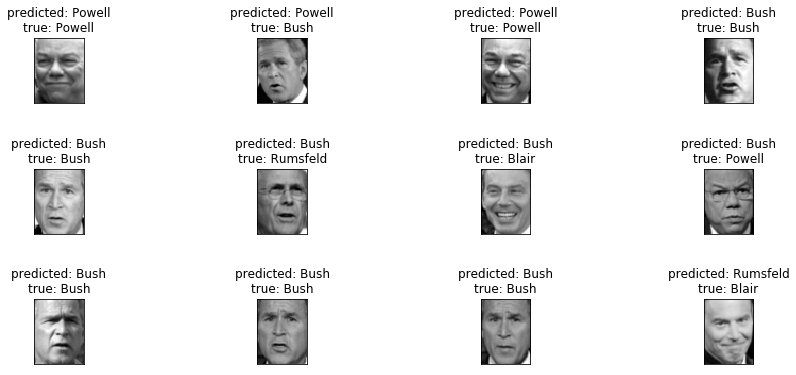

In [20]:
# observe some of the images with their predicted and true labels
prediction_titles = list(titles(y_predkNN, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

# Things I think I can improve
 - Balance the data: I have observed that the classifier is predicting 'Bush' in most cases
 - Increase the number of eigenfaces


## Balance the data using SMOTE

SMOTE generates synthetic data

We are going to generate synthetic photos! So cool!!!!

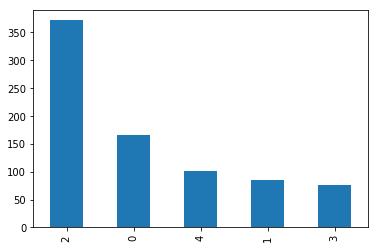

In [21]:
# observe imbalance in original data
pd.Series(y_train).value_counts().plot.bar()

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

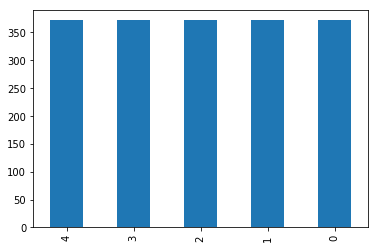

In [24]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [0]:
# convert to dataframe to make it easy to separate synthetic data from original
X_train_newDF = pd.DataFrame(X_train_new)
X_trainDF = pd.DataFrame(X_train)

In [0]:
# collect synthetic data
synth = X_train_newDF[~X_train_newDF.isin(X_trainDF)].dropna()

In [27]:
synth.shape

(1057, 2914)

In [0]:
synth = np.array(synth)

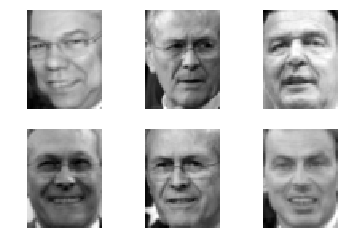

In [29]:
# plot synthetic photos
np.random.seed(4)
idx = np.random.choice(len(synth), size = 6)
for i in range(6):
  plt.subplot(2, 3, i+1), plt.imshow(synth[idx[i]].reshape(h, w), cmap = 'gray'), plt.axis('off')

I am so impressed!

# SVD on new balanced data

In [0]:
U, S, VT = np.linalg.svd(X_train_new, full_matrices=False) 

In [31]:
print(U.shape, S.shape, VT.shape)

(1855, 1855) (1855,) (1855, 2914)


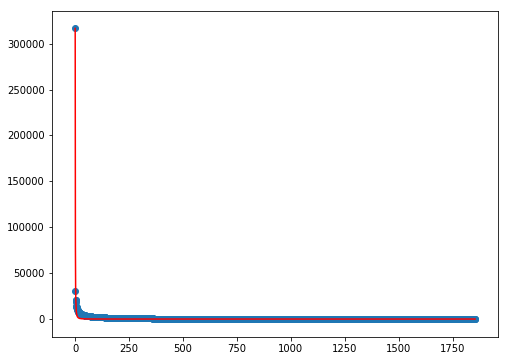

In [32]:
# observe how quickly singular values diminish - approximately as fast as sigma0/(i+1)^2
idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]

plt.figure(figsize = (8, 6))
plt.plot(idx, func, color = 'r')
plt.scatter(idx, S)

## Start by exploring cumulative variance explained by the Singular Vectors

Text(0.5, 1.0, 'Explained Variance')

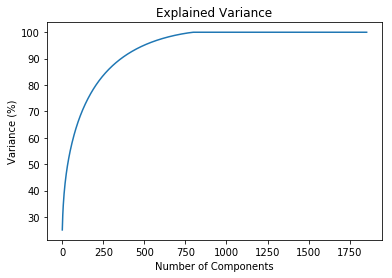

In [33]:
sum_singular_vals = np.sum(S)
variance_ratio = S / sum_singular_vals

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(variance_ratio) * 100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')

At around 750 components, all of the variance is preserved. So, let's preserve 750 components

In [0]:
num_components = 750

In [0]:
# transform both train and test data into new face space
X_train_transformed = X_train_new @ VT[:num_components,:].T
X_test_transformed = X_test @ VT[:num_components,:].T

In [36]:
print(X_train.shape, X_train_transformed.shape)

(798, 2914) (1855, 750)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6a0a187860>,
 Text(0.5, 1.0, 'Image in new face space'))

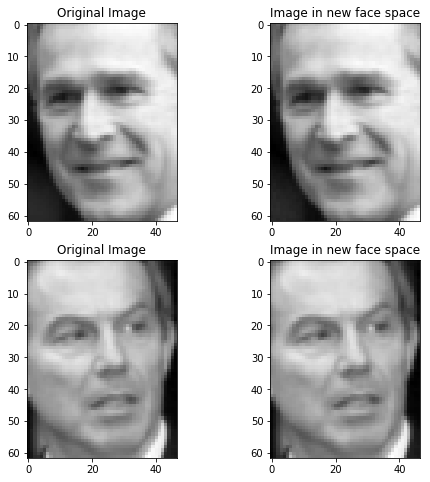

In [37]:
# visualize images after encoding as linear combination of eigenfaces
reconst0 = X_train_transformed[0] @ VT[: num_components, :]
reconst1 = X_train_transformed[1] @ VT[: num_components, :]

plt.figure(figsize = (8, 8))
plt.subplot(2, 2, 1), plt.imshow(X_train[0].reshape(h, w), cmap = plt.cm.gray), plt.title('Original Image')
plt.subplot(2, 2, 2), plt.imshow(reconst0.reshape(h, w), cmap = plt.cm.gray), plt.title('Image in new face space')
plt.subplot(2, 2, 3), plt.imshow(X_train[1].reshape(h, w), cmap = plt.cm.gray), plt.title('Original Image')
plt.subplot(2, 2, 4), plt.imshow(reconst1.reshape(h, w), cmap = plt.cm.gray), plt.title('Image in new face space')

# kNN

In [38]:
clfkNN = KNeighborsClassifier()
clfkNN.fit(X_train_transformed, y_train_new)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [39]:
y_predkNN = clfkNN.predict(X_test_transformed)
print(classification_report(y_test, y_predkNN, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.57      0.76      0.65        71
  Donald Rumsfeld       0.38      0.64      0.47        36
    George W Bush       0.97      0.36      0.52       159
Gerhard Schroeder       0.31      0.61      0.41        33
       Tony Blair       0.39      0.58      0.47        43

         accuracy                           0.52       342
        macro avg       0.52      0.59      0.51       342
     weighted avg       0.69      0.52      0.53       342



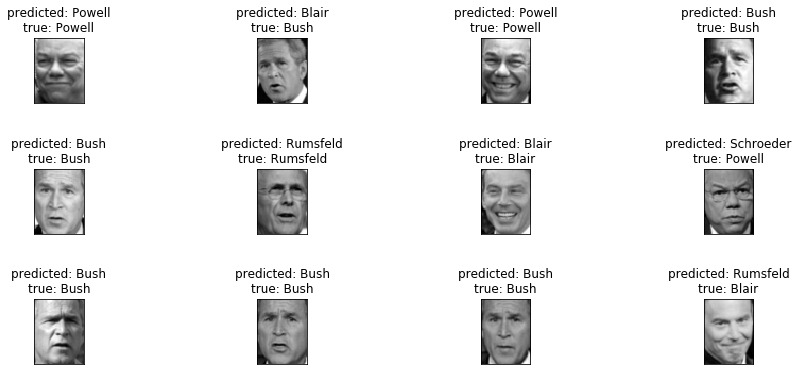

In [40]:
# observe some of the images with their predicted and true labels
prediction_titles = list(titles(y_predkNN, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

## MLP

In [41]:
# neural network
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True, random_state = 42).fit(X_train_transformed, y_train_new)

Iteration 1, loss = inf
Validation score: 0.403226
Iteration 2, loss = 40.49049601
Validation score: 0.709677
Iteration 3, loss = 18.66115427
Validation score: 0.962366
Iteration 4, loss = 1.96183984
Validation score: 0.935484
Iteration 5, loss = 1.96552977
Validation score: 0.983871
Iteration 6, loss = 0.15178069
Validation score: 0.994624
Iteration 7, loss = 0.03085964
Validation score: 0.983871
Iteration 8, loss = 0.00017437
Validation score: 0.978495
Iteration 9, loss = 0.00017271
Validation score: 0.978495
Iteration 10, loss = 0.00017057
Validation score: 0.978495
Iteration 11, loss = 0.00016909
Validation score: 0.978495
Iteration 12, loss = 0.00016709
Validation score: 0.978495
Iteration 13, loss = 0.00016521
Validation score: 0.978495
Iteration 14, loss = 0.00016324
Validation score: 0.978495
Iteration 15, loss = 0.00016169
Validation score: 0.978495
Iteration 16, loss = 0.00016019
Validation score: 0.978495
Iteration 17, loss = 0.00015891
Validation score: 0.978495
Validation 

In [42]:
y_pred = clf.predict(X_test_transformed)
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.89      0.89      0.89        71
  Donald Rumsfeld       0.76      0.78      0.77        36
    George W Bush       0.86      0.92      0.89       159
Gerhard Schroeder       0.72      0.64      0.68        33
       Tony Blair       0.81      0.67      0.73        43

         accuracy                           0.84       342
        macro avg       0.81      0.78      0.79       342
     weighted avg       0.84      0.84      0.84       342



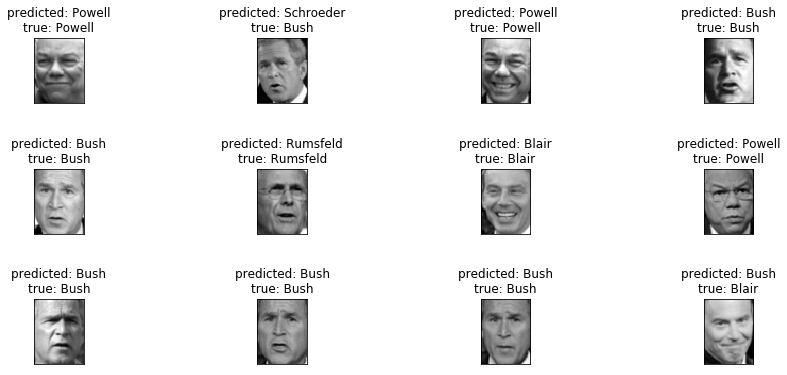

In [43]:
# observe some of the images with their predicted and true labels
prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)